## Version incorporating corrections and suggestions made by reviewer

# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import project_tests as t

import itertools
from difflib import SequenceMatcher

from collections import OrderedDict

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import re

[nltk_data] Downloading package punkt to /home/brunom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brunom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brunom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Load user-item interactions file

In [3]:
df = pd.read_csv('data/user-item-interactions.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


#### Check number of unique users

In [4]:
df.email.unique().shape[0]

5149

#### There are missing emails

In [5]:
df[df.email.isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


#### Load contents file

In [6]:
df_content = pd.read_csv('data/articles_community.csv')
df_content.drop('Unnamed: 0', axis=1, inplace=True)
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

#### There are 5149 unique users, 5148 with valid emails and 17 null emails which were grouped as a single email.

In [7]:
total_email_entries = df.email.unique().shape[0] 
null_email_entries = df[df.email.isnull()].shape[0]
print('Total email entries: ', total_email_entries)
print('Null email entries: ', null_email_entries)
print('Valid users: ', total_email_entries - 1)

Total email entries:  5149
Null email entries:  17
Valid users:  5148


#### 50% of users interact with 3 articles. Outliers interacted with as many as 364 articles. 

In [8]:
df_ = df.groupby('email').agg({'article_id':'size'})\
.rename(columns={'article_id':'number_articles'})
df_.describe()

,number_articles
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


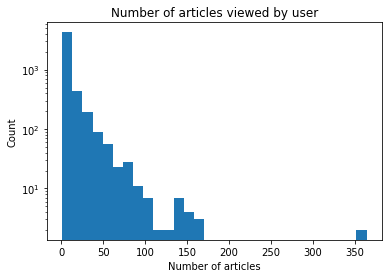

In [9]:
plt.hist(df_.number_articles, bins=30, log=True)
plt.xlabel('Number of articles')
plt.ylabel('Count')
plt.title('Number of articles viewed by user');

In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = df_.median()[0] # 50% of individuals interact with _ number of articles or fewer.
max_views_by_user = df_.max()[0] # The maximum number of user-article interactions by any 1 user is _.
print('median val: ',median_val)
print('max views by user: ', max_views_by_user)

median val:  3.0
max views by user:  364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

#### Initial shape of df_content

In [11]:
df_content.shape

(1056, 5)

#### There are duplicate articles

In [12]:
df_content.drop_duplicates(subset=['article_id']).shape

(1051, 5)

#### All were dropped except for the first occurrence

In [13]:
df_content.drop_duplicates(subset=['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

#### Number of unique articles that have an interaction with a user: 714


In [14]:
unique_articles = df.article_id.unique().shape[0]

In [15]:
df.email.unique().shape

(5149,)

#### Number of unique articles in dataset: 1051

In [16]:
total_articles = df_content.article_id.unique().shape[0]
print('total number of articles: ',total_articles)

total number of articles:  1051


#### Number of unique users in dataset: 5148 and one null

In [17]:
unique_users = df.email.unique().shape[0]
print('number of unique users: ',unique_users)

number of unique users:  5149


#### Number of user-article interactions in dataset: 45993

In [18]:
user_article_interactions = df.shape[0]
print('user-article interactions: ', user_article_interactions)

user-article interactions:  45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

#### Top 5 most viewed articles were 1430, 1314, 1429, 1338, 1276


In [19]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


#### Create dataframe containining aggregated information about articles

In [20]:
df_articles = df.groupby('article_id').size().sort_values(ascending=False).reset_index().rename(columns={0:'count'})
df_articles.head()

,article_id,count
0,1429.0,937
1,1330.0,927
2,1431.0,671
3,1427.0,643
4,1364.0,627


In [21]:
# The most viewed article in the dataset as a string with one value follow
most_viewed_article_id = str(df_articles.iloc[0,0])
# The most viewed article in the dataset was viewed how many times?
max_views = df_articles.iloc[0,1] # The most viewed article in the dataset was viewed how many times?
print('most_viewed_article_id: ', most_viewed_article_id)
print('max_vies: ', max_views)

most_viewed_article_id:  1429.0
max_vies:  937


In [22]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded


df_tmp = df.copy()

email_encoded = email_mapper()
#del df_tmp['email']
df_tmp['user_id'] = email_encoded

# show header
df_tmp.head()

,article_id,title,email,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


#### apply email_mapper

In [23]:
df['user_id'] = email_mapper()

#### There are 714 unique articles

In [24]:
df.article_id.unique().shape

(714,)

In [25]:
unique_users = df.dropna().email.unique().shape[0]
unique_users

5148

In [26]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [27]:
def get_top_articles(n, df=df):
    '''
    INPUT:  n - (int) the number of top articles to return
            df - (pandas dataframe) df as defined at the top of the notebook 
    OUTPUT:
            top_articles - (list) A list of the top 'n' article titles 
    '''
    
    return df.groupby(['article_id','title']).agg({'email':'size'}).rename(columns={'email':'count'}).\
    sort_values('count', ascending=False).reset_index()['title'].tolist()[:n]

In [28]:
get_top_articles(5, df)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [29]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:  n - (int) the number of top articles to return
            df - (pandas dataframe) df as defined at the top of the notebook 
    OUTPUT: top_articles - (list) A list of the top 'n' article titles 
    '''
    # Your code here
    return df.\
        groupby('article_id').\
        agg({'email':'size'}).\
        sort_values('email', ascending=False).reset_index().iloc[0:n,0].tolist()[:n]

In [30]:
print(get_top_article_ids(5, df))

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]


In [31]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [32]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT: df - pandas dataframe with article_id, title, user_id columns
    OUTPUT: user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    return pd.crosstab(df['user_id'], df['article_id']).applymap(lambda x: 1 if x>0 else 0)

In [33]:
user_item = create_user_item_matrix(df)

In [34]:
np.unique(user_item.values)

array([0, 1])

In [35]:
user_item.shape

(5149, 714)

In [36]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."

print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [37]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT: user_id - (int) a user_id
           user_item - (pandas dataframe) matrix of users by articles: 
           1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT: similar_users - (list) an ordered list where the closest users (largest dot product users)
            are listed first
    
    Description: Computes the similarity of every pair of users based on the dot product
                 Returns an ordered
    '''
     
    target_array = user_item.iloc[user_id-1,:].values
    dot_product = user_item.dot(target_array).drop(user_id).reset_index()
    return dot_product.sort_values(by=[0, 0], ascending=False)['user_id'].tolist()

In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [39]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_ids = [float(i) for i in article_ids]
    return df.set_index('article_id').loc[article_ids, 'title'].unique().tolist()

In [40]:
article_ids=[0.0,2.0]
get_article_names(article_ids)

['detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)']

In [41]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    if (user_item.index == user_id).any():
        article_ids = (user_item.loc[user_id,:]).where(lambda x: x>0).dropna().sort_values(ascending=False).index
        article_ids = [str(i) for i in article_ids]
        article_names = get_article_names(article_ids)
    else:
        article_names = get_top_articles(10, df)
        article_ids = get_top_article_ids(10, df)
    
    return article_ids, article_names # return the ids and names



In [42]:
user_id = 3

article_ids, article_names = get_user_articles(user_id)
article_ids[:5], article_names[:5]

(['1436.0', '1432.0', '788.0', '784.0', '735.0'],
 ['welcome to pixiedust',
  'visualize data with the matplotlib library',
  'quick guide to build a recommendation engine in python',
  '10 data science, machine learning and ai podcasts you must listen to',
  'making sense of the bias / variance trade-off in (deep) reinforcement learning'])

In [43]:
user_id = 10000

article_ids, article_names = get_user_articles(user_id)
article_ids[:5], article_names[:5]

([1429.0, 1330.0, 1431.0, 1427.0, 1364.0],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm'])

In [44]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = find_similar_users(user_id)
    recs = []
    for user in similar_users:
        _, article_names = get_user_articles(user)
        recs.extend(article_names)

    return recs[:m] # return your recommendations for this user_id    

In [45]:
user_id=1
recs = user_user_recs(user_id)
recs

['working with ibm cloud object storage in r',
 'new shiny cheat sheet and video tutorial',
 'working with ibm cloud object storage in python',
 'python if statements explained (python for data science basics #4)',
 'rapidly build machine learning flows with dsx',
 'shiny: a data scientist’s best friend',
 'analyze db2 warehouse on cloud data in rstudio in dsx',
 'tidyverse practice: mapping large european cities',
 'python for loops explained (python for data science basics #5)',
 'super fast string matching in python']

In [46]:
get_user_articles(20)

(['1320.0', '844.0', '232.0'],
 ['housing (2015): united states demographic measures',
  'use the cloudant-spark connector in python notebook',
  'self-service data preparation with ibm data refinery'])

In [47]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [48]:
def get_articles(user):
    '''
    Returns a list with the articles viewed by user
    Input: user id
    Output: list with articles
    '''
    return user_item.loc[user,:].where(lambda x: x>0).dropna().index.tolist()

In [49]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    target_array = user_item.iloc[user_id-1,:].values
    df_ = user_item.dot(target_array).to_frame('similarity').reset_index()
    num_interactions = df.groupby('user_id').size()
    df_['num_interactions'] = df_['user_id'].map(lambda x: num_interactions[x])
    return df_[df_['user_id'] != user_id].sort_values(['similarity','num_interactions'], ascending=False).reset_index()

In [50]:
user_id = 131
df_ = get_top_sorted_users(user_id, df=df, user_item=user_item)
df_.head(11)

,index,user_id,similarity,num_interactions
0,3869,3870,74,144
1,3781,3782,39,363
2,22,23,38,364
3,202,203,33,160
4,4458,4459,33,158
5,97,98,29,170
6,3763,3764,29,169
7,48,49,29,147
8,3696,3697,29,145
9,241,242,25,148


In [51]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    df_ = get_top_sorted_users(user_id, df=df, user_item=user_item)
    target_read, _ = get_user_articles(user_id)
    rank_articles = df.groupby('article_id').size().sort_values(ascending=False).index

    recommend = []

    for user in df_.user_id.tolist():
        user_read, _ = get_user_articles(user, user_item=user_item)
        recommend.extend([i for i in rank_articles if str(i) in user_read])

    recs = (list(OrderedDict.fromkeys(recommend)))
    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]

In [52]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [53]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1, df=df, user_item = user_item).user_id.values[0]
print('user1_most_sim ', user1_most_sim)
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).user_id.values[9]
print('user131_10th_sim ', user131_10th_sim)

user1_most_sim  3933
user131_10th_sim  242


In [54]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

`Answer` 

If we were given a new user, our first approach would be to use function get_top_articles because we don't have previous information about article interactions and preferences. In the absence of information about the user I consider it is hardly possible to suggest anything better than the aggregated article readership ranking.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [55]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = list(map(lambda x: str(x), get_top_article_ids(10, df)))

In [56]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [57]:
def tokenize(sentence):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    return [lemmatizer.lemmatize(word).lower().strip() for word in nltk.word_tokenize(sentence)\
            if not word in stop_words] 

In [58]:
def dot_tokens_compare(tokens, tokens_user):
    
    countVect = CountVectorizer(min_df=10,  stop_words="english", ngram_range=(1, 2))
    df_message_vect = countVect.fit_transform(tokens)
    target = countVect.transform(tokens_user).transpose()

    return (df_message_vect * target).sum(axis=1)

In [59]:
def make_content_recs(df_content, user_id, m=10):
    '''
    INPUT: df_content - pandas dataframe with article content
           user_id - user id
           m - number of recommendations to return
    
    OUTPUT: list of recommendations by article name  
    '''
    user_articles = get_user_articles(user_id, user_item=user_item)[0]

    df_articles = df.merge(df_content.copy(), left_on='article_id', right_on='article_id', how='left').\
    drop_duplicates('article_id')
    df_articles['full_text'] = df_articles.apply(lambda x: str(x.title) + 
                                             str(x.doc_description) + 
                                             str(x.doc_full_name), axis=1)
    df_articles.drop(['doc_description', 'doc_full_name'], axis=1, inplace=True)
    df_articles['tokenized'] = df_articles['full_text'].apply(lambda x: " ".join(tokenize(x)))
    df_articles = df_articles.merge(df.groupby('article_id').agg({'article_id':'count'}).\
                                    rename(columns={'article_id':'article_count'}), 
          left_on='article_id', right_on='article_id', how='left')
  
    df_articles['score'] = dot_tokens_compare(df_articles['tokenized'], 
                                              df_articles[df_articles.article_id.isin(user_articles)]['tokenized'])
    
    return df_articles.sort_values(['score','article_count'], ascending=False)['title'][:m].tolist()

In [60]:
content_recs = make_content_recs(df_content, 1)
display(content_recs)

['data visualization playbook: telling the data story',
 'r for data science',
 '66855    migration from ibm bluemix data connect api (a...\nName: title, dtype: object',
 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics',
 'use ibm data science experience to read and write data stored on amazon s3',
 'tidy data in python',
 'use ibm data science experience to detect time series anomalies',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'this week in data science (may 30, 2017)',
 'data science experience demo: modeling energy usage in nyc']

In [61]:
rec_ids, rec_names = user_user_recs_part2(1, 10)
display(rec_names)

['use deep learning for image classification',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'welcome to pixiedust',
 'deep learning with tensorflow course by big data university',
 'classify tumors with machine learning',
 'putting a human face on machine learning',
 'gosales transactions for naive bayes model']

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

`Answer` 

The content-based recommendation system follows the sequence of steps outlined below:

1. merge in a single dataframe information about article content and article readership
2. merge content (doc description, doc full name) as a single string
3. tokenize this string: stemmer, lemmatizer, lowercase, remove spaces
4. generate bag or words (vectorize) using the cleaned-up strings
5. get articles viewed by user. Process and vectorize them. 
6. calculate score: dot product between user articles and all others
7. select articles with highest scores
8. in case of draw, select most popular articles

An easy improvement for this recommender is to include collaborative recommendations to the scoring function. The scoring could be calculated as a linear combination of content-based and collaborative-based recommendations. 

Taking user number 1 as a reference, all top 10 collaborative-based recommended articles were different from the content-based recommended ones. Certainly this method is exploring a different facet of this user.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [62]:
# make recommendations for a brand new user
content_recs = make_content_recs(df_content, 10000)
content_recs

['machine learning for everyone',
 'use the machine learning library',
 'ibm watson machine learning: get started',
 'the difference between ai, machine learning, and deep learning?',
 'build deep learning architectures with neural network modeler',
 'ml algorithm != learning machine',
 'create a project for watson machine learning in dsx',
 'deep learning with data science experience',
 'apple, ibm add machine learning to partnership with watson-core ml coupling',
 '8 ways to turn data into value with apache spark machine learning']

In [63]:
# make a recommendations for a user who only has interacted with article id '1427.0'
new_index = user_item.index.max()+1
user_item.loc[new_index, '1427.0'] = 1

In [64]:
make_content_recs(df_content, new_index)

['ibm watson machine learning: get started',
 'machine learning for everyone',
 'apple, ibm add machine learning to partnership with watson-core ml coupling',
 'create a project for watson machine learning in dsx',
 'ml algorithm != learning machine',
 'building your first machine learning system ',
 'use the machine learning library',
 'machine learning for the enterprise.',
 'machine learning for the enterprise',
 'watson machine learning for developers']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [65]:
# Load the matrix here
user_item_matrix_2 = pd.read_pickle('user_item_matrix.p')
user_item_matrix_2.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,1017.0,1018.0,102.0,1024.0,1025.0,1028.0,103.0,1030.0,1035.0,1038.0,1042.0,1043.0,1044.0,1047.0,1048.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,1065.0,1066.0,1067.0,1068.0,1069.0,107.0,1070.0,1071.0,1072.0,1073.0,1074.0,1075.0,1077.0,1078.0,1079.0,108.0,1080.0,1083.0,1084.0,1085.0,1086.0,1089.0,109.0,1091.0,1092.0,1097.0,110.0,1101.0,1106.0,1108.0,111.0,1112.0,1113.0,1114.0,1116.0,1119.0,112.0,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1127.0,1128.0,113.0,1130.0,1134.0,1135.0,1137.0,1138.0,1139.0,1140.0,1141.0,1142.0,1143.0,1144.0,1145.0,1146.0,1147.0,1148.0,1149.0,115.0,1150.0,1151.0,1152.0,1153.0,1154.0,1155.0,1156.0,1157.0,1158.0,1159.0,116.0,1160.0,1161.0,1162.0,1163.0,1164.0,1165.0,1166.0,1167.0,1168.0,1169.0,117.0,1170.0,1171.0,1172.0,1173.0,1174.0,1175.0,1176.0,1177.0,1178.0,1179.0,1180.0,1181.0,1183.0,1184.0,1185.0,1186.0,1187.0,1188.0,1189.0,1190.0,1191.0,1192.0,1195.0,1196.0,1197.0,1198.0,1199.0,12.0,120.0,1200.0,1202.0,1203.0,1206.0,1208.0,1210.0,1219.0,122.0,1221.0,1225.0,1226.0,1227.0,1228.0,1230.0,1232.0,1233.0,1234.0,1235.0,1237.0,124.0,1244.0,1247.0,125.0,1251.0,1252.0,1253.0,1254.0,1257.0,1260.0,1261.0,1263.0,1266.0,1267.0,1271.0,1273.0,1274.0,1276.0,1277.0,1278.0,1279.0,1280.0,1281.0,1282.0,1283.0,1285.0,1286.0,1289.0,1290.0,1291.0,1292.0,1293.0,1294.0,1295.0,1296.0,1297.0,1298.0,1299.0,130.0,1303.0,1304.0,1305.0,1306.0,1307.0,1308.0,131.0,1313.0,1314.0,1315.0,1317.0,1318.0,1319.0,132.0,1320.0,1321.0,1324.0,1326.0,1328.0,1329.0,1330.0,1331.0,1332.0,1333.0,1334.0,1335.0,1336.0,1337.0,1338.0,134.0,1340.0,1343.0,1344.0,1346.0,1348.0,1349.0,1350.0,1351.0,...,428.0,429.0,43.0,430.0,437.0,440.0,443.0,444.0,446.0,448.0,455.0,460.0,462.0,463.0,464.0,465.0,468.0,470.0,473.0,474.0,475.0,477.0,479.0,48.0,480.0,482.0,485.0,486.0,491.0,492.0,494.0,495.0,499.0,50.0,500.0,502.0,504.0,508.0,51.0,510.0,515.0,517.0,521.0,522.0,524.0,525.0,528.0,53.0,532.0,534.0,54.0,542.0,544.0,547.0,553.0,555.0,557.0,559.0,563.0,564.0,566.0,567.0,569.0,57.0,575.0,58.0,583.0,585.0,586.0,588.0,59.0,593.0,599.0,60.0,600.0,606.0,607.0,609.0,610.0,616.0,617.0,618.0,62.0,622.0,626.0,631.0,632.0,634.0,636.0,64.0,641.0,644.0,645.0,647.0,65.0,651.0,653.0,655.0,656.0,658.0,659.0,662.0,665.0,667.0,668.0,669.0,670.0,673.0,675.0,677.0,678.0,679.0,68.0,680.0,681.0,682.0,684.0,686.0,692.0,693.0,695.0,701.0,705.0,708.0,714.0,715.0,720.0,721.0,722.0,723.0,724.0,725.0,727.0,729.0,730.0,732.0,735.0,74.0,740.0,744.0,749.0,751.0,757.0,758.0,759.0,76.0,760.0,761.0,763.0,764.0,766.0,768.0,77.0,778.0,78.0,781.0,782.0,784.0,785.0,788.0,793.0,795.0,8.0,80.0,800.0,805.0,809.0,81.0,812.0,813.0,82.0,821.0,825.0,833.0,843.0,844.0,846.0,853.0,855.0,857.0,858.0,861.0,862.0,864.0,865.0,868.0,87.0,870.0,871.0,876.0,878.0,880.0,881.0,882.0,884.0,887.0,89.0,891.0,892.0,896.0,898.0,9.0,903.0,905.0,906.0,910.0,911.0,919.0,92.0,926.0,928.0,930.0,932.0,933.0,935.0,936.0,939.0,940.0,941.0,943.0,947.0,948.0,949.0,951.0,952.0,955.0,957.0,958.0,959.0,96.0,961.0,962.0,965.0,967.0,968.0,969.0,972.0,973.0,974.0,975.0,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [66]:
user_item_matrix_2.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [67]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix_2, full_matrices=True)

In [68]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

`Answer`

Plain SVD worked in this case because there are no missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

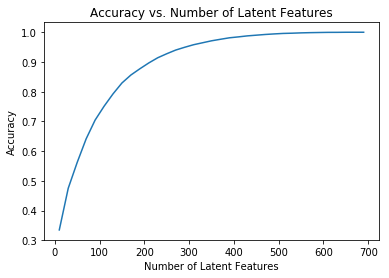

In [69]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix_2, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use. Simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [70]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

#### Read again user-item interactions file

In [71]:
df_train = df.head(40000).copy()
df_test = df.tail(5993).copy()

In [72]:
user_item_train, user_item_test, test_idx, test_arts =create_test_and_train_user_item(df_train, df_test)
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [73]:
np.unique(user_item_train.values)

array([0, 1])

In [74]:
users_in_test_only = len(set(user_item_test.index).difference(set(user_item_train.index)))
users_in_test_only

662

In [75]:
users_predict_possible = len(test_idx) - users_in_test_only
users_predict_possible

20

In [76]:
articles_in_test_only = len(set(user_item_test.columns).difference(set(user_item_train.columns)))
articles_in_test_only

0

In [77]:
articles_predict_possible = len(test_arts) - articles_in_test_only
articles_predict_possible

574

In [78]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': users_predict_possible, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': users_in_test_only, 
    'How many articles can we make predictions for in the test set?': articles_predict_possible,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': articles_in_test_only
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [79]:
user_item_test.shape, user_item_train.shape

((682, 574), (4487, 714))

#### list users_train_test has all user ids common to both training and testing sets

In [80]:
users_train_test = list(set(user_item_train.index).intersection(set(user_item_test.index)))
users_train_test_idx = [i-1 for i in users_train_test]

#### list articles_train_test contains all article ids common to both training and testing sets

In [81]:
articles_train_test = list(set(user_item_train.columns).intersection(set(user_item_test.columns)))

#### list articles_train_test_idx has the column numbers for the items listed in articles_train_test

In [82]:
articles_train_test_idx = [user_item_train.columns.get_loc(i) for i in articles_train_test]
len(articles_train_test_idx)

574

In [83]:
def svd_error_train_test(x):
    """
    This function predicts the recommendation value and compares it with the corresponding value
    in the test set
    
    INPUT: x - number of latent features
    OUTPUT: train and test errors
    """
    s_new, u_train_new, vt_train_new = np.diag(s_train[:x]), u_train[:,:x], vt_train[:x,:]
    u_test_new, vt_test_new = u_test[:,:x], vt_test[:x,:]
    
    train_preds = np.around(np.dot(np.dot(u_train_new,s_new),vt_train_new))
    test_preds = np.around(np.dot(np.dot(u_test_new,s_new),vt_test_new))
    
    diff_train = np.subtract(user_item_train, train_preds)
    diff_test = np.subtract(user_item_test.loc[users_train_test,:], test_preds)
    
    error_train = np.sum(np.sum(np.abs(diff_train)))
    error_test = np.sum(np.sum(np.abs(diff_test)))
    

    return [error_train, error_test]


#### Calculate SVD decomposition for training set

In [84]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)
u_test = u_train[users_train_test_idx,:] 
vt_test = vt_train[:, articles_train_test_idx]

In [104]:
svd_df = pd.DataFrame(np.arange(20, 700, 10), columns=['latent_feats'])
 
svd_df = pd.concat([svd_df, pd.DataFrame(svd_df['latent_feats'].\
                                         apply(lambda x: svd_error_train_test(x)).tolist(), 
                                         columns=['error_train','error_test'])], axis=1)

svd_df['accuracy_train'] = svd_df.error_train.apply(lambda x: 1 - x/df_train.shape[0]) 
svd_df['accuracy_test'] = svd_df.error_test.apply(lambda x: 1 - x/df_test.shape[0])

In [86]:
svd_df.head()

,latent_feats,error_train,error_test,accuracy_train,accuracy_test
0,20,23460.0,260.0,0.41350,0.956616
1,30,20886.0,269.0,0.47785,0.955114
2,40,19010.0,276.0,0.52475,0.953946
3,50,17312.0,283.0,0.56720,0.952778
4,60,15662.0,294.0,0.60845,0.950943


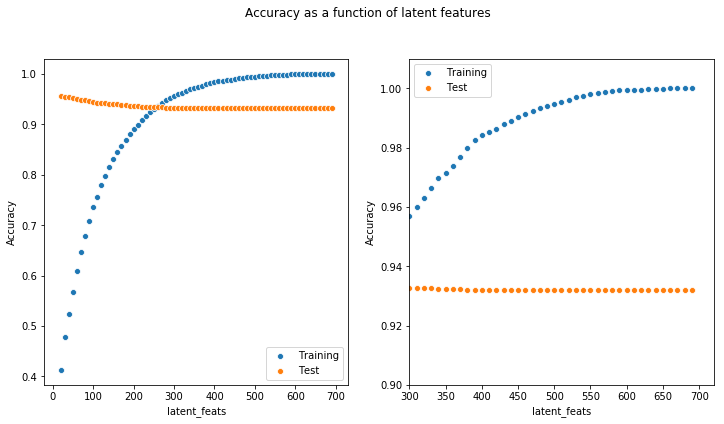

In [103]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(x = 'latent_feats', y = 'accuracy_train', data=svd_df, ax=ax1, label='Training')
sns.scatterplot(x = 'latent_feats', y = 'accuracy_test', data=svd_df, ax=ax1, label='Test');
ax1.set_ylabel('Accuracy')
ax1.legend()
sns.scatterplot(x = 'latent_feats', y = 'accuracy_train', data=svd_df, ax=ax2, label='Training')
sns.scatterplot(x = 'latent_feats', y = 'accuracy_test', data=svd_df, ax=ax2, label='Test');
ax2.set_xlim([300,720])
ax2.set_ylim([0.9,1.01])
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.suptitle('Accuracy as a function of latent features', y=1.0);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

`Answer`

__Comment on the results from previous question:__

The result shows that while training accuracy grows, test accuracy diminishes with the number of latent features. The crossover point is around 250 latent features. This result was somewhat unexpected since test accuracy should in general be smaller thn training accuracy. A possible reason might be the imbalance between the sizes of the sets, given that test set is only 15% the size of training set. A reduced number of latent features would greatly impact the much larger training matrix by constraining the mixing between users and movies and thereby limiting the reproducibility of the original matrix. The analysis should be performed using more than 300 latent features where the normal behaviour is recovered.

__How to determine if the recommendations are an improvement:__

Given the circumstances of the results obtained above, a possible way to assess if the new recommendation systems are an improvement compared to the old ones is to perform A/B testing. This sequence of tests would compare each of the new systems separately against the old systems. Three new systems would be tested:

1. Collaborative recommendation
2. Content recommendation
3. SVD recommendation

Since the recommendation system is only for users with accounts, it is straightforward to divide them in control and experimental groups. The assessment metric would be number of times each user accesses its recommended articles. A significant difference between control and experimental groups implies that the recommendations were well-suited to specific user preferences. 

For collaborative recommendation the test would follow this sequence of steps:

1. Stratify user accounts by number of articles viewed and equally divide each of the stratified groups in control and test sets.
2. Keep control group receiving recommendations from the old recommendation system. Start collecting article accesses and store them in a new dataset. Keep generating new recommendations based on the new articles.
3. Gather all articles viewed by all members of the experimental group and generate recommendations using function `user_user_recs_part2`. Collect new article accesses and store them in a separate dataset. Keep generating new recommendation based on these new accesses.
4. After a period of time, calculated based on the power of the test, compare the average new accesses for control and experimental sets. Comparisons should involve a t-test and confidence intervals calculations.
5. Adopt the new system if there is evidence that it is better than the old system.

## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 
